In [6]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [27]:
original_data_df = pd.read_excel('data/heart_disease_male.xls', skiprows=[1], na_values=['#NAME?', '?']).bfill()
original_data_df.head()

,age,chest_pain_type,rest_blood_pressure,blood_sugar,rest_electro,max_heart_rate,exercice_angina,disease
0,43,asympt,140,False,normal,135,yes,positive
1,39,atyp_angina,120,False,normal,160,yes,negative
2,39,non_anginal,160,True,normal,160,no,negative
3,42,non_anginal,160,False,normal,146,no,negative
4,49,asympt,140,False,normal,130,no,negative


In [28]:
original_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  209 non-null    int64 
 1   chest_pain_type      209 non-null    object
 2   rest_blood_pressure  209 non-null    int64 
 3   blood_sugar          209 non-null    bool  
 4   rest_electro         209 non-null    object
 5   max_heart_rate       209 non-null    int64 
 6   exercice_angina      209 non-null    object
 7   disease              209 non-null    object
dtypes: bool(1), int64(3), object(4)
memory usage: 11.8+ KB


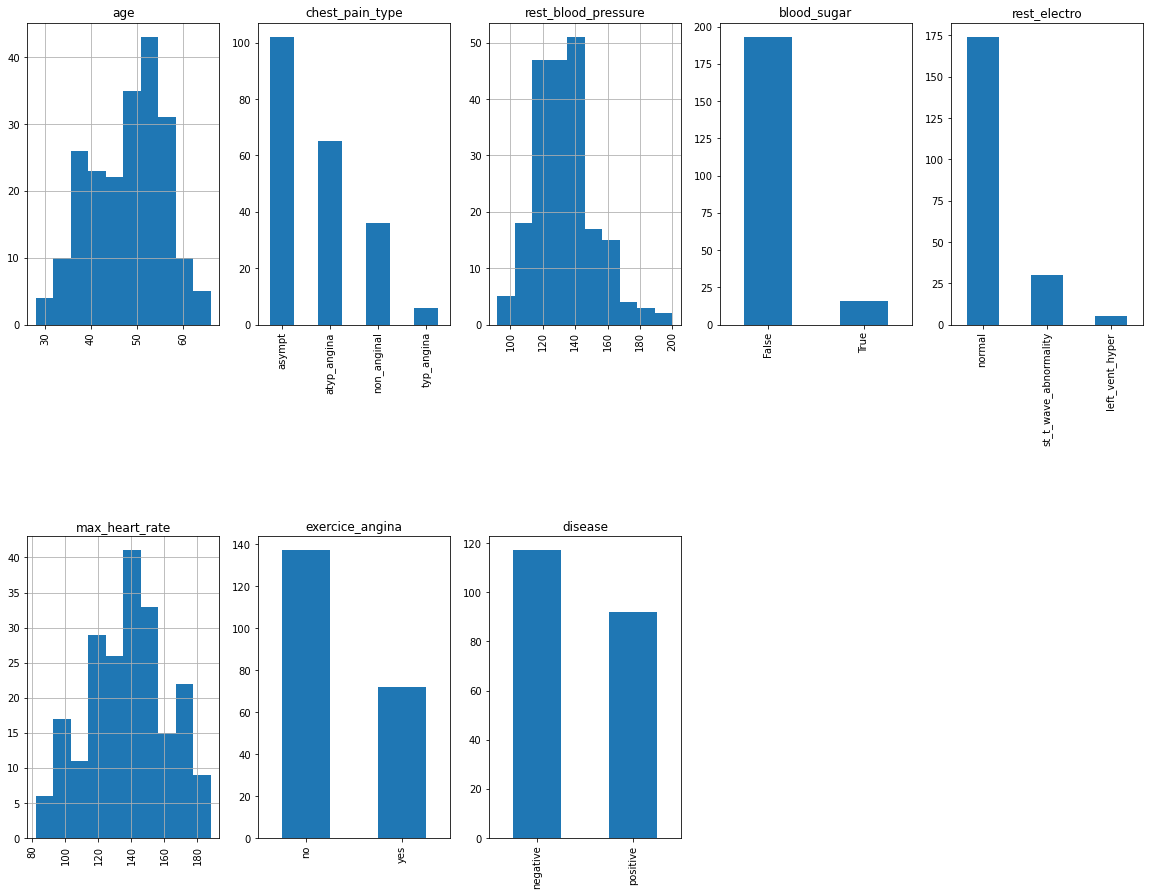

In [29]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(original_data_df.shape[1]) / cols)
for i, column in enumerate(original_data_df.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if (original_data_df.dtypes[column] == np.object) | (original_data_df.dtypes[column] == np.bool):
        original_data_df[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_data_df[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

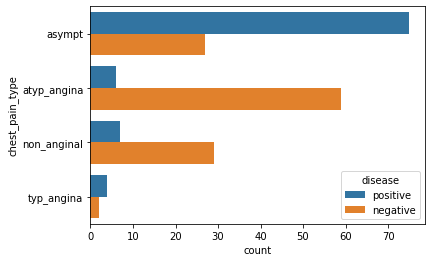

In [41]:
sns.countplot(y='chest_pain_type', hue='disease', data=original_data_df)

In [31]:
from sklearn.preprocessing import LabelEncoder

# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].astype(str))
    return result

encoded_data = number_encode_features(original_data_df)
encoded_data.head()

,age,chest_pain_type,rest_blood_pressure,blood_sugar,rest_electro,max_heart_rate,exercice_angina,disease
0,43,0,140,False,1,135,1,1
1,39,1,120,False,1,160,1,0
2,39,2,160,True,1,160,0,0
3,42,2,160,False,1,146,0,0
4,49,0,140,False,1,130,0,0


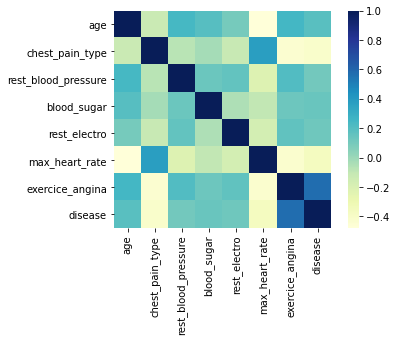

In [32]:
sns.heatmap(encoded_data.corr(), square=True, cmap="YlGnBu")

In [33]:
original_data_df[['exercice_angina', 'disease']].head(10)

,exercice_angina,disease
0,yes,positive
1,yes,negative
2,no,negative
3,no,negative
4,no,negative
5,no,negative
6,yes,positive
7,yes,positive
8,no,positive
9,yes,positive


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report


def train_and_test(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    
    y_predicted = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,y_predicted)
    
    y_probability_estimates = classifier.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test,y_probability_estimates)
    
    classification_rep = classification_report(y_test,y_predicted)
    con_matrix = confusion_matrix(y_test,y_predicted)
    fpr, tpr, _ = roc_curve(y_test,y_probability_estimates)
    

    # ploting confustion matrix
    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    sns.heatmap(con_matrix, annot=True, fmt="d" )
    plt.ylabel("Real value")
    plt.xlabel("Predicted value")
    plt.show()

    # print scores
    print ("accuracy  score: {} %".format(accuracy))
    print ("auc  score: {} ".format(roc_auc))
    print(classification_rep)

    # print ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

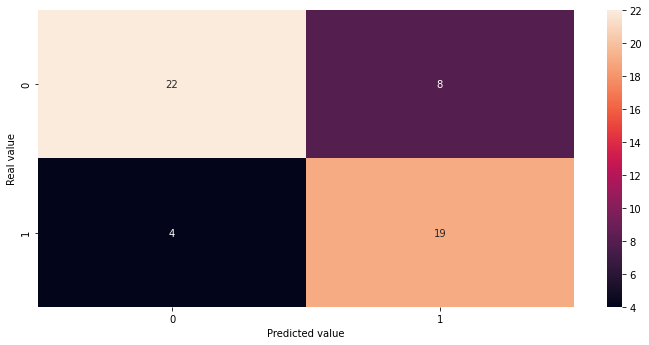

accuracy  score: 0.7735849056603774 %
auc  score: 0.9072463768115941 
              precision    recall  f1-score   support

           0       0.85      0.73      0.79        30
           1       0.70      0.83      0.76        23

    accuracy                           0.77        53
   macro avg       0.77      0.78      0.77        53
weighted avg       0.78      0.77      0.77        53



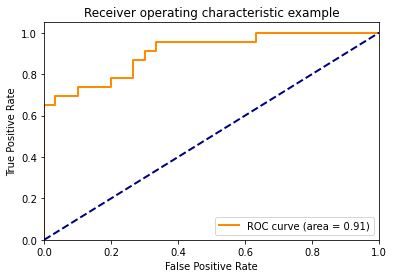

In [35]:
from sklearn.naive_bayes import GaussianNB
# from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# #  to fill the NaN Values
# imp = SimpleImputer(strategy= 'most_frequent')
# data = imp.fit_transform(original_data_df)

data = original_data_df.copy()
data ['exercice_angina'] = [False if x == 'no' else True for x in data['exercice_angina']]
data_dummies = pd.get_dummies(data)

features = data_dummies.loc[:,'age':'rest_electro_st_t_wave_abnormality']
target = data_dummies.loc[:, 'disease_positive']

X_unprocessed = features.values
y_unprocessed = target.values

X_train, X_test, y_train, y_test = train_test_split(X_unprocessed, y_unprocessed, random_state=1, stratify=y_unprocessed)

model = GaussianNB()
train_and_test(model, X_train, X_test, y_train, y_test)

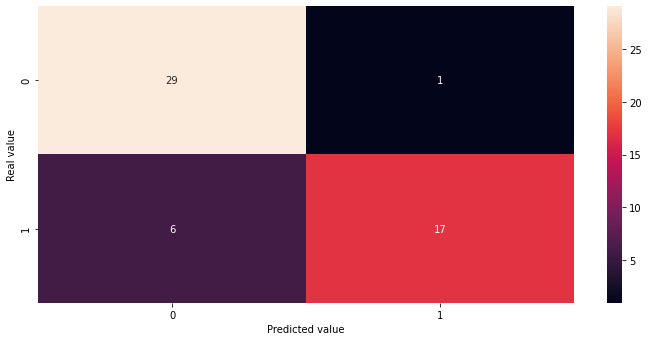

accuracy  score: 0.8679245283018868 %
auc  score: 0.8688405797101448 
              precision    recall  f1-score   support

           0       0.83      0.97      0.89        30
           1       0.94      0.74      0.83        23

    accuracy                           0.87        53
   macro avg       0.89      0.85      0.86        53
weighted avg       0.88      0.87      0.86        53



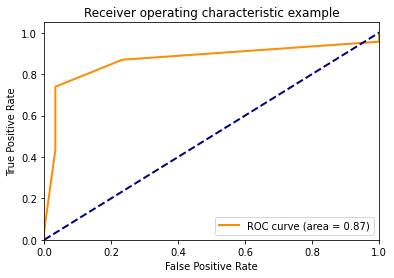

In [36]:
from sklearn.tree import DecisionTreeClassifier
train_and_test(DecisionTreeClassifier(criterion='entropy', max_depth=3), X_train, X_test, y_train, y_test)